In [1]:
# Standard library imports
import sys

# Contributed library imports
import geopandas as gpd
import numpy as np

# Our imports
from multiview_mapping_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_mapping_toolkit.utils.prediction_metrics import compute_and_show_cf
from multiview_mapping_toolkit.utils.geospatial import get_overlap_vector

sys.path.append("../..")
from constants_80m import (
    get_IDs_to_labels,
    get_numpy_export_cf_filename,
    get_predicted_vector_labels_filename,
    get_predicted_polygons_labels_filename,
    get_mesh_filename,
    get_camera_filename,
    get_DTM_filename,
    get_numpy_export_faces_texture_filename,
    get_mesh_transform_filename,
    LABELS_COLUMN,
    LABELS_FILENAME,
    BUFFER_RADIUS_METERS,
    HEIGHT_ABOVE_GROUND_THRESH,
    GROUND_WEIGHT_POLYGON_LABELING,
)

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set constants
You should be able to define most of the behavior from these constants

In [2]:
PREDICTION_SITE = "lassic"
TRAINING_SITES = sorted(["chips", "delta", "valley"])

In [3]:
IDs_TO_LABELS = get_IDs_to_labels()

In [4]:
NUMPY_EXPORT_CONFUSION_MATRIX_FILE = get_numpy_export_cf_filename(
    PREDICTION_SITE, training_sites=TRAINING_SITES, is_ortho=False
)

# Ground truth classes

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture
Could not read texture as a scalar from the pyvista mesh
Could not read texture as a numpy file


Sampling values from raster /ofo-share/scratch-derek/organized-str-disp-MVMT-experiments_80m/per_site_processing/lassic/02_photogrammetry/exports/dtms/lassic.tif: 100%|██████████| 466389/466389 [00:19<00:00, 24171.35it/s]


This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


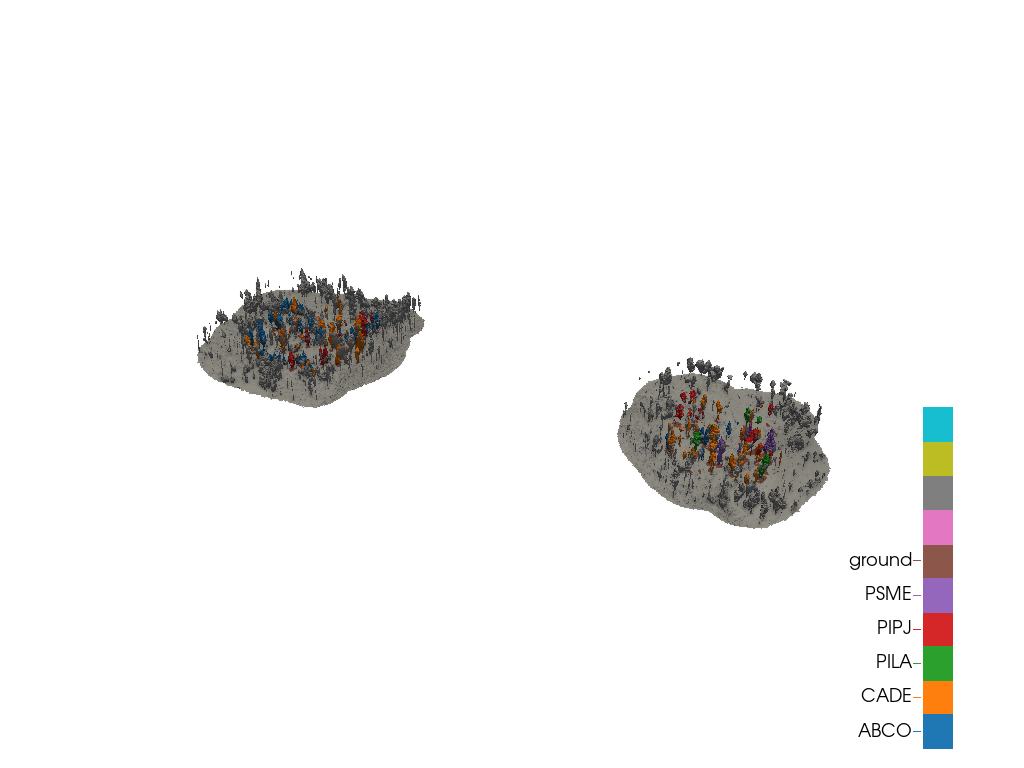

In [5]:
MESH_FILENAME = get_mesh_filename(PREDICTION_SITE)
CAMERAS_FILENAME = get_camera_filename(PREDICTION_SITE)
DTM_FILE = get_DTM_filename(PREDICTION_SITE)
TRANSFORM_FILENAME = get_mesh_transform_filename(PREDICTION_SITE)

mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=TRANSFORM_FILENAME,
    texture=LABELS_FILENAME,
    texture_column_name=LABELS_COLUMN,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.label_ground_class(
    height_above_ground_threshold=HEIGHT_ABOVE_GROUND_THRESH,
    DTM_file=DTM_FILE,
    set_mesh_texture=True,
)
mesh.vis(force_xvfb=True)

# Per-polygon labeling using the mesh from above for convenience

Sampling values from raster /ofo-share/scratch-derek/organized-str-disp-MVMT-experiments_80m/per_site_processing/lassic/02_photogrammetry/exports/dtms/lassic.tif: 100%|██████████| 466389/466389 [00:18<00:00, 24664.18it/s]


Weighting shape (927165,)
Computing faces in working CRS


/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
Converting faces to polygons: 100%|██████████| 927165/927165 [00:13<00:00, 66685.95it/s]

Creating dataframe of faces


Starting overlay


/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Overlay time: 238.33672738075256
        polygon_ID  class_ID  ratio_3d_2d  face_weighting  \
0              0.0       0.0     2.337461        2.337461   
1              0.0       1.0    17.806571       17.806571   
2              0.0       1.0     5.934590        5.934590   
3              0.0       0.0     2.433627        2.433627   
4              0.0       3.0     9.884274        9.884274   
...            ...       ...          ...             ...   
207057       168.0       4.0     1.579941        1.579941   
207058       168.0       3.0     1.174253        1.174253   
207059       168.0       3.0     1.661802        1.661802   
207060       168.0       3.0     3.548955        3.548955   
207061       168.0       3.0     3.710278        3.710278   

                                                 geometry  weighted_area  
0       POLYGON ((451639.068 4461318.160, 451638.911 4...       1.401581  
1       POLYGON ((451641.210 4461317.758, 451640.794 4...       0.222991  
2       P

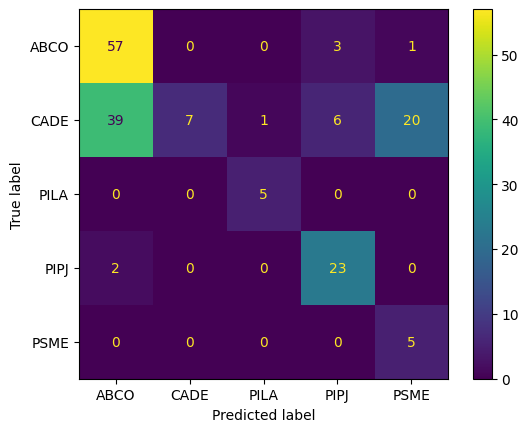

Accuracy: 0.5739644970414202


In [6]:
predicted_face_classes_filename = get_numpy_export_faces_texture_filename(
    prediction_site=PREDICTION_SITE, training_sites=TRAINING_SITES
)
# TODO consider masking no prediction faces
predicted_face_classes = np.argmax(np.load(predicted_face_classes_filename), axis=1)

ground_mask = mesh.get_height_above_ground(
    DTM_file=DTM_FILE,
    threshold=HEIGHT_ABOVE_GROUND_THRESH,
)
ground_mask_faces = mesh.vert_to_face_texture(ground_mask)

# Ground points get a weighting of 0.01, others get 1
weighting = 1 - (1 - GROUND_WEIGHT_POLYGON_LABELING) * ground_mask_faces.astype(float)

polygons = gpd.read_file(LABELS_FILENAME).query("fire==@PREDICTION_SITE")

predicted_filename = get_predicted_polygons_labels_filename(
    PREDICTION_SITE, TRAINING_SITES, False
)

print(f"Weighting shape {weighting.shape}")
predicted_class_labels = mesh.label_polygons(
    predicted_face_classes, polygons, face_weighting=weighting
)
polygons["predicted_labels"] = predicted_class_labels
polygons.to_file(predicted_filename)

gt_list = polygons[LABELS_COLUMN]
cf, classes, accuracy = compute_and_show_cf(
    pred_labels=predicted_class_labels,
    gt_labels=gt_list,
    labels=list(IDs_TO_LABELS.values()),
)
np.save(NUMPY_EXPORT_CONFUSION_MATRIX_FILE, cf)
print(f"Accuracy: {accuracy}")

# Predicted classes

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture
This method will be deprecated in favor of get_IDs_to_labels since it doesn't handle non-sequential indices


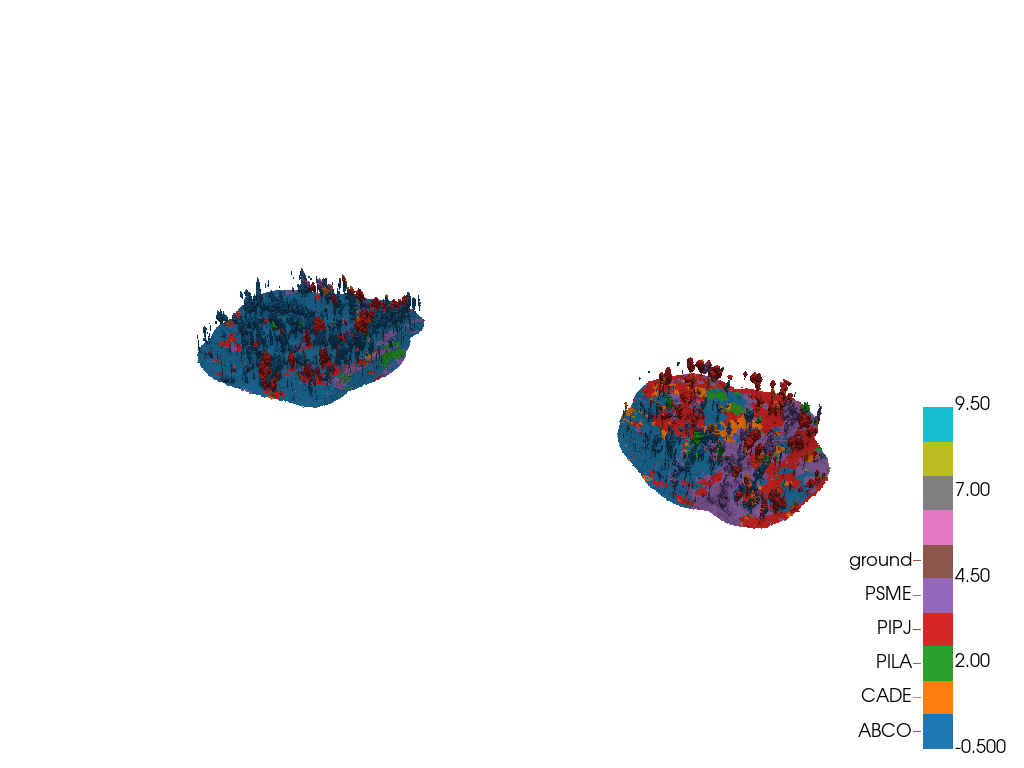

In [7]:
MESH_TRANSFORM = get_mesh_transform_filename(PREDICTION_SITE)
NUMPY_EXPORT_FACES_TEXTURE_FILE = get_numpy_export_faces_texture_filename(
    PREDICTION_SITE, training_sites=TRAINING_SITES
)
predicted_texture = np.argmax(np.load(NUMPY_EXPORT_FACES_TEXTURE_FILE), axis=1)

mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=MESH_TRANSFORM,
    texture=predicted_texture,
    IDs_to_labels=IDs_TO_LABELS,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)

# Colored mesh

In [8]:
mesh = TexturedPhotogrammetryMesh(
    MESH_FILENAME,
    transform_filename=CAMERAS_FILENAME,
    ROI=LABELS_FILENAME,
    ROI_buffer_meters=BUFFER_RADIUS_METERS,
)
mesh.vis(force_xvfb=True)

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Standardizing ROI
Dissolving ROI
Setting CRS and buffering ROI
Dissolving buffered ROI
Extracting verts for dataframe
Checking intersection of verts with ROI
Extracting points from pyvista mesh
Extraction surface from subset mesh
Extracting faces from mesh
Loading texture
No texture provided


ValueError: Empty meshes cannot be plotted. Input mesh has zero points.